In [1]:
import re
import numpy as np
from statistics import mean, stdev
import matplotlib.pyplot as plt
from bento_bench import bar_plot, parse_elapsed_secs
import seaborn as sns
fsl = ["Bento-fs", "Bento-user", "Bento-prov", "ext4-ordered", "ext4-journal"]
tl = [1, 18]

{'Bento-fs': [33.766999999999996, 165.06799999999998], 'Bento-user': [37.865, 167.606], 'Bento-prov': [34.21, 165.18], 'ext4-ordered': [34.541, 165.739], 'ext4-journal': [37.016, 168.482]}
{'Bento-fs': [1.708, 0.482], 'Bento-user': [1.78, 1.02], 'Bento-prov': [1.911, 0.499], 'ext4-ordered': [1.1869999999999998, 0.526], 'ext4-journal': [1.222, 0.575]}


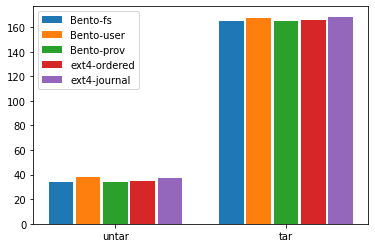

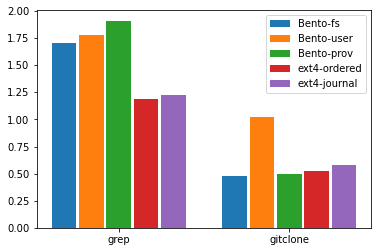

In [2]:
otherapps_1 = ["untar", "tar"]
otherapps_2 = ["grep", "gitclone"]
otherapps_results_1 = {}
otherapps_results_2 = {}
for fs in fsl:
	otherapps_results_1[fs] = []
	for app in otherapps_1:
		tmp = []
		dir = "./results/" + fs + "/" + app
		for f in os.listdir(dir):
			i = int(f.split("_")[1])
			fr = open(dir + "/" + f, 'r')
			t = fr.read()
			fr.close()
			matches = re.findall("\d*:\d*.\d*(?=elapsed)", t)
			tmp.append(parse_elapsed_secs(matches[0]))
		otherapps_results_1[fs].append(mean(tmp))
	otherapps_results_2[fs] = []
	for app in otherapps_2:
		tmp = []
		dir = "./results/" + fs + "/" + app
		for f in os.listdir(dir):
			i = int(f.split("_")[1])
			fr = open(dir + "/" + f, 'r')
			t = fr.read()
			fr.close()
			matches = re.findall("\d*:\d*.\d*(?=elapsed)", t)
			tmp.append(parse_elapsed_secs(matches[0]))
		otherapps_results_2[fs].append(mean(tmp))
print(otherapps_results_1)
print(otherapps_results_2)

fig, ax = plt.subplots()
#bax = brokenaxes(ylims=((0, 10), (25, 50), (150, 170)), hspace=.1)
bar_plot(ax, otherapps_results_1, fsl, total_width=.8, single_width=.9)
plt.xticks(range(len(otherapps_1)), otherapps_1)
plt.show()
fig, ax = plt.subplots()
#bax = brokenaxes(ylims=((0, 10), (25, 50), (150, 170)), hspace=.1)
bar_plot(ax, otherapps_results_2, fsl, total_width=.8, single_width=.9)
plt.xticks(range(len(otherapps_2)), otherapps_2)
plt.show()

#width =0.3
#for i, fs in enumerate(fsl):
#	plt.bar(np.arange(len(otherapps_results[fs])) + i * width, otherapps_results[fs], width=width)
#plt.xticks(range(len(otherapps)), otherapps)
#plt.show()

{'Bento-fs': [13.0364623, 11.9022662], 'Bento-user': [13.036091800000001, 13.3242299], 'Bento-prov': [12.777818900000002, 12.300950400000001], 'ext4-ordered': [14.234438500000001, 14.003521800000001], 'ext4-journal': [13.9769209, 13.4250801]}
{'Bento-fs': [48.769999999999996, 70.46000000000001], 'Bento-user': [45.18, 67.86], 'Bento-prov': [47.57, 70.64], 'ext4-ordered': [41.16, 69.59], 'ext4-journal': [39.7, 67.54]}


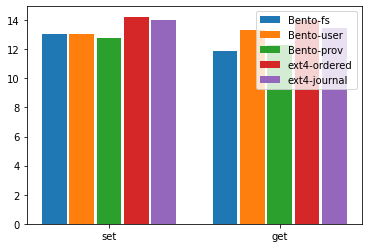

In [11]:
redis = ["set", "get"]
rocksdb = ["fillrandom", "readrandom"]
redis_results = {}
rocksdb_results = {}

for fs in fsl:
	redis_results[fs] = []
	tmp_set = []
	tmp_get = []
	dir = "./results/" + fs + "/redis"
	for f in os.listdir(dir):
		i = int(f.split("_")[1])
		fr = open(dir + "/" + f, 'r')
		t = fr.read()
		fr.close()
		matches = re.findall("\d*.\d*(?= requests per second)", t)
		tmp_set.append(float(matches[0]) * 0.0001) # convert
		tmp_get.append(float(matches[1]) * 0.0001) # convert
	redis_results[fs].append(mean(tmp_set))
	redis_results[fs].append(mean(tmp_get))

	rocksdb_results[fs] = []
	tmp_fillrandom = []
	tmp_readrandom = []
	dir = "./results/" + fs + "/rocksdb"
	for f in os.listdir(dir):
		i = int(f.split("_")[1])
		fr = open(dir + "/" + f, 'r')
		t = fr.read()
		fr.close()
		matches = re.findall("\d*.\d*(?= MB/s)", t)
		tmp_fillrandom.append(float(matches[0]))
		tmp_readrandom.append(float(matches[1]))
	rocksdb_results[fs].append(mean(tmp_fillrandom))
	rocksdb_results[fs].append(mean(tmp_readrandom))

print(redis_results)
print(rocksdb_results)
fig, ax = plt.subplots()
#bax = brokenaxes(ylims=((0, 10), (25, 50), (150, 170)), hspace=.1)
bar_plot(ax, redis_results, fsl, total_width=.8, single_width=.9)
plt.xticks(range(len(redis)), redis)
plt.show()